<a href="https://colab.research.google.com/github/oshan35/ColorAnalyzer/blob/master/Vanila_Unet_512_MnM2_UNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [8]:
!pip install torch
!pip install nibabel
!pip PIL
!pip install numpy
!pip install torchio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: unknown command "PIL"
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
import nibabel as nb
import matplotlib.pyplot as plt
import numpy as np
import sys

# Access the data

In [10]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Visualize Data

In [11]:
def plot_images(dir,train_or_test,la_or_sa,ed_or_es,id):

  img = nb.load(dir+train_or_test+"/"+id+"/"+id+"_"+la_or_sa+"_"+ed_or_es+".nii").get_fdata()

  mask = nb.load(dir+train_or_test+"/"+id+"/"+id+"_"+la_or_sa+"_"+ed_or_es+"_gt.nii").get_fdata()
  
  print(img.shape,mask.shape,mask.min(),mask.max())

  viz_dict = {"Image": img[:,:,0], "Segmentation Map": mask[:,:,0]}

  fig = plt.figure(figsize=(15, 15))

  count = 2

  for i, j in viz_dict.items():
    ax = plt.subplot(1, 3, count)
    plt.imshow(j)
    plt.title(i)
    plt.axis("on")
    count += 1

(256, 256, 1) (256, 256, 1) 0.0 3.0


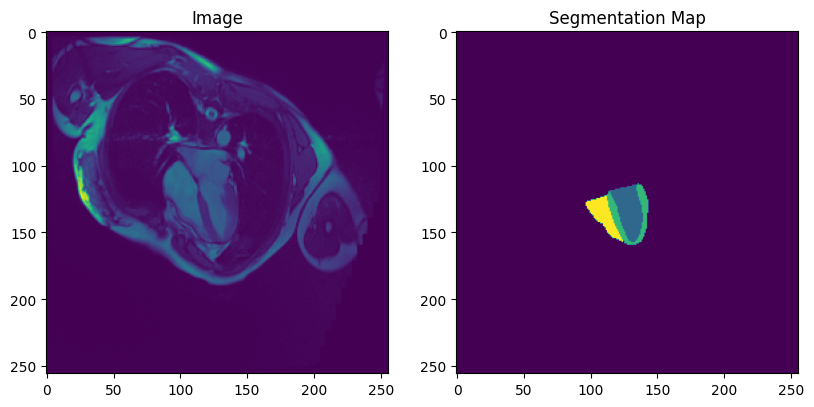

In [12]:
#plot_images('/content/drive/MyDrive/oshan_dataset/expanded/MnM-2/','training','LA','ES','001')
plot_images('/content/drive/MyDrive/Final-Year-Project/MnM-Dataset/MnM-2/','training','LA','ES','001')

# Choose dataset

In [13]:
import glob

def select_data(datatype_anotation):
  #file_input = '/content/drive/MyDrive/oshan_dataset/expanded/MnM-2/training/*/*'+datatype_anotation+'*'
  file_input = '/content/drive/MyDrive/Final-Year-Project/MnM-Dataset/MnM-2/training/*/*'+datatype_anotation+'*'
  return glob.glob(file_input)

data_type_LA_ED = '_LA_ED'

file_names_LA_ED = select_data(data_type_LA_ED)

In [14]:
data_type_LA_ES = '_LA_ES'

file_names_LA_ES = select_data(data_type_LA_ES)

In [15]:
data_type_SA_ED = '_SA_ED'

file_names_SA_ED = select_data(data_type_SA_ED)

In [16]:
data_type_SA_ES = '_SA_ES'

file_names_SA_ES = select_data(data_type_SA_ES)

In [17]:
file_names = file_names_LA_ED + file_names_LA_ES # + file_names_SA_ED + file_names_SA_ES # cant' add SA to LA cz its 3D

In [18]:
images_raw = []
masks_raw = []

for file_name in file_names:
  if 'gt' not in file_name:
    img = nb.load(file_name).get_fdata()
    images_raw.append(img)
  else:
    mask = nb.load(file_name).get_fdata()
    masks_raw.append(mask)


In [19]:
for file_name in file_names:
  if 'gt' not in file_name:
    img = nb.load(file_name).get_fdata()
    if img.shape[2] != 1:
      print(file_name)
  else:
    mask = nb.load(file_name).get_fdata()
    if mask.shape[2] != 1:
      print(file_name)

In [20]:
from skimage.transform import resize

images = []
masks = []

for img, msk in zip(images_raw,masks_raw):
  bottle_img = resize(img, (200,200))
  bottle_mask = resize(msk, (200,200))

  images.append(bottle_img)
  masks.append(bottle_mask)

In [21]:
images = np.asarray(images, dtype=np.float32)
masks = np.asarray(masks, dtype=np.int16)
masks = masks.reshape(320,200,200)

# Visualizing after selection

In [22]:
def plot_images_after_cleaning(img,mask):
  
  print(img.shape,mask.shape,mask.min(),mask.max())

  viz_dict = {"Image": img[:,:,0], "Segmentation Map": mask}

  fig = plt.figure(figsize=(15, 15))

  count = 2

  for i, j in viz_dict.items():
    ax = plt.subplot(1, 3, count)
    plt.imshow(j)
    plt.title(i)
    plt.axis("on")
    count += 1

(200, 200, 1) (200, 200) 0 3


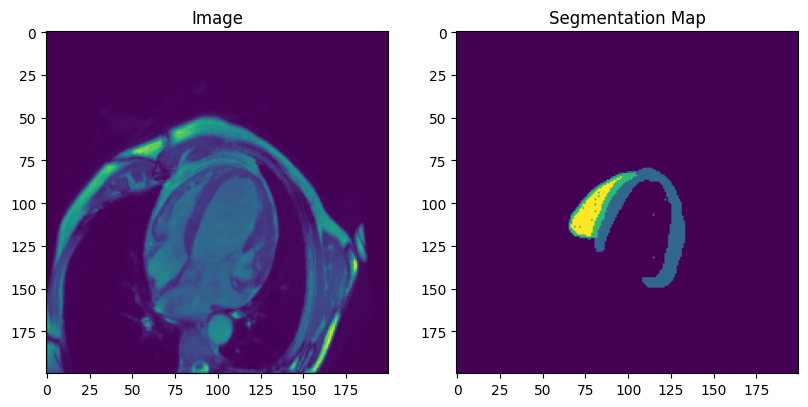

In [23]:
plot_images_after_cleaning(images[100],masks[100])

In [24]:
# Mean and StD for this dataset

print(images.shape) 
print(images.mean(axis=(0,1,2))/255) 
print(images.std(axis=(0,1,2))/255)


dataset_mean, dataset_std = images.mean(axis=(0,1,2))/255 , images.std(axis=(0,1,2))/255


# print(masks.shape) 
# print(masks.mean(axis=(0,1,2))/255) 
# print(masks.std(axis=(0,1,2))/255)

# mask_mean, mask_std = masks.mean(axis=(0,1,2))/255 , masks.std(axis=(0,1,2))/255

(320, 200, 200, 1)
[0.44121042]
[0.6976652]


# Transforms

In [25]:
import torchvision.transforms as transforms

def replace_tensor_value_(tensor):
    return tensor

input_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(dataset_mean, dataset_std)
    ]
)

targets_transform = transforms.Compose(
    [
        transforms.ToTensor()
    ]
)

# Hyperparams

In [26]:
import torch

learning_rate = 0.0001
batch_size = 14
num_epochs = 1000

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('The current processor is ...', device)

The current processor is ... cuda


# Test Train Split

In [27]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split


class MyDataset(Dataset):
  def __init__(self, data, targets, transform=None, target_transform=None):
    self.data = data
    self.targets = targets

    self.transform = transform
    self.target_transform = target_transform
    
  def __getitem__(self, index):
    x = self.data[index]
    y = self.targets[index]
        
    if self.transform:
      x = self.data[index]
      x = self.transform(x)

    return x, y
    
  def __len__(self):
    return len(self.data)

X_train, X_test, y_train, y_test = train_test_split(images, masks,
                                                    test_size=0.20,
                                                    random_state=33)

train_dataset = MyDataset(X_train, y_train, transform=input_transform, target_transform=targets_transform)

test_dataset = MyDataset(X_test, y_test, transform=input_transform, target_transform=targets_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size)

test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [28]:
inputs, classes = next(iter(train_loader))
inputs.shape, inputs.min(), inputs.max(), classes.shape, classes.min(), classes.max()

(torch.Size([14, 1, 200, 200]),
 tensor(-0.6324),
 tensor(3550.2651),
 torch.Size([14, 200, 200]),
 tensor(0, dtype=torch.int16),
 tensor(3, dtype=torch.int16))

# UNet Model

In [29]:
""" Parts of the U-Net model """

import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        # print("-------------------")
        # print("Inside Up layer")
        # print(f"up layer input size {x1.size()}")
        x1 = self.up(x1)
        # print(f"after transpose layer input size {x1.size()}")
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        # print(f"diffy: {diffY}, diffx: {diffX}")

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # print(f"applying pad {x1.size()}")
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        # print(f"applying cat {x.size()}")
        # print("-------------------")
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [30]:
""" Full assembly of the parts to form the complete network """

class UNet(nn.Module):

        
  def __init__(self, n_channels, n_classes, bilinear=False):
      super(UNet, self).__init__()
      self.n_channels = n_channels
      self.n_classes = n_classes
      self.bilinear = bilinear

      self.inc = DoubleConv(n_channels, 64)
      self.down1 = Down(64, 128)
      self.down2 = Down(128, 256)
      factor = 2 if bilinear else 1
      self.down3 = Down(256, 512// factor)
      self.up1 = Up(512, 256 // factor, bilinear)
      self.up2 = Up(256, 128 // factor, bilinear)
      self.up3 = Up(128, 64, bilinear)
      self.outc = OutConv(64, n_classes)

  def forward(self, x):

      x1 = self.inc(x)
    
      x2 = self.down1(x1)

      x3 = self.down2(x2)

      x4 = self.down3(x3)

      x = self.up1(x4, x3)

      x = self.up2(x, x2)

      x = self.up3(x, x1)

      logits = self.outc(x)

      return logits

In [31]:
import torch
from torch import Tensor


def dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon=1e-6):
    # Average of Dice coefficient for all batches, or for a single mask
    assert input.size() == target.size()
    if input.dim() == 2 and reduce_batch_first:
        raise ValueError(f'Dice: asked to reduce batch but got tensor without batch dimension (shape {input.shape})')

    if input.dim() == 2 or reduce_batch_first:
        inter = torch.dot(input.reshape(-1), target.reshape(-1))
        sets_sum = torch.sum(input) + torch.sum(target)
        if sets_sum.item() == 0:
            sets_sum = 2 * inter

        return (2 * inter + epsilon) / (sets_sum + epsilon)
    else:
        # compute and average metric for each batch element
        dice = 0
        for i in range(input.shape[0]):
            dice += dice_coeff(input[i, ...], target[i, ...])
        return dice / input.shape[0]


def multiclass_dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon=1e-6):
    # Average of Dice coefficient for all classes
    assert input.size() == target.size()
    dice = 0
    for channel in range(input.shape[1]):
        dice += dice_coeff(input[:, channel, ...], target[:, channel, ...], reduce_batch_first, epsilon)

    return dice / input.shape[1]


def dice_loss(input: Tensor, target: Tensor, multiclass: bool = False):
    # Dice loss (objective to minimize) between 0 and 1
    assert input.size() == target.size()
    fn = multiclass_dice_coeff if multiclass else dice_coeff
    return 1 - fn(input, target, reduce_batch_first=True)

In [32]:
import numpy as np
from sklearn.metrics.pairwise import pairwise_distances
import skimage.io
from torch import nn

In [33]:
def averaged_hausdorff_distance(set1, set2, max_ahd=np.inf):
    """
    Compute the Averaged Hausdorff Distance function
    between two unordered sets of points (the function is symmetric).
    Batches are not supported, so squeeze your inputs first!
    :param set1: Array/list where each row/element is an N-dimensional point.
    :param set2: Array/list where each row/element is an N-dimensional point.
    :param max_ahd: Maximum AHD possible to return if any set is empty. Default: inf.
    :return: The Averaged Hausdorff Distance between set1 and set2.
    """

    if len(set1) == 0 or len(set2) == 0:
        return max_ahd

    set1 = torch.flatten(set1, start_dim = 1)
    set2 = torch.flatten(set2, start_dim = 1)

    set1 = np.array(set1)
    set2 = np.array(set2)

    assert set1.ndim == 2, 'got %s' % set1.ndim
    assert set2.ndim == 2, 'got %s' % set2.ndim

    assert set1.shape[1] == set2.shape[1], \
        'The points in both sets must have the same number of dimensions, got %s and %s.'\
        % (set2.shape[1], set2.shape[1])

    d2_matrix = pairwise_distances(set1, set2, metric='euclidean')

    res = np.average(np.min(d2_matrix, axis=0)) + \
        np.average(np.min(d2_matrix, axis=1))

    return res

In [34]:
tensor1 = torch.randn(2, 2)
tensor2 = torch.randn(2, 2)

In [35]:
print(averaged_hausdorff_distance(tensor1, tensor2))

3.2291422


In [36]:
net = UNet(n_channels=1, n_classes=4, bilinear=False).to(device=device)

# Training

In [37]:
# import torch.optim as optim
# from torch.optim.lr_scheduler import StepLR

# optimizer = optim.RMSprop(net.parameters(), lr=learning_rate, weight_decay=1e-8, momentum=0.9)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score

# grad_scaler = torch.cuda.amp.GradScaler(enabled=False)
# criterion = nn.CrossEntropyLoss()
# global_step = 0


import torch.optim as optim
#from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import CosineAnnealingLR

optimizer = optim.RMSprop(net.parameters(), lr=learning_rate, weight_decay=1e-8, momentum=0.9)
#optimizer = optim.Adam(net.parameters(), lr=learning_rate)
#scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor = 0.5 ,patience=16)  # goal: maximize Dice score
scheduler = CosineAnnealingLR(optimizer, T_max=10)
grad_scaler = torch.cuda.amp.GradScaler(enabled=False)
criterion = nn.CrossEntropyLoss()
global_step = 0

In [38]:
from torchsummary import summary

summary(net,(1,200,200))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 200, 200]             576
       BatchNorm2d-2         [-1, 64, 200, 200]             128
              ReLU-3         [-1, 64, 200, 200]               0
            Conv2d-4         [-1, 64, 200, 200]          36,864
       BatchNorm2d-5         [-1, 64, 200, 200]             128
              ReLU-6         [-1, 64, 200, 200]               0
        DoubleConv-7         [-1, 64, 200, 200]               0
         MaxPool2d-8         [-1, 64, 100, 100]               0
            Conv2d-9        [-1, 128, 100, 100]          73,728
      BatchNorm2d-10        [-1, 128, 100, 100]             256
             ReLU-11        [-1, 128, 100, 100]               0
           Conv2d-12        [-1, 128, 100, 100]         147,456
      BatchNorm2d-13        [-1, 128, 100, 100]             256
             ReLU-14        [-1, 128, 1

In [39]:
class EarlyStopping:
  def __init__(self, patience=5, threshold=1e-4):
    self.patience = patience
    self.threshold = threshold
    self.best_loss = np.inf
    self.counter = 0
  
  def stop_training(self, val_loss):
    if val_loss < self.best_loss - self.threshold:
      self.best_loss = val_loss
      self.counter = 0
    else:
      self.counter += 1
      if self.counter >= self.patience:
        return True
    return False

early_stopping = EarlyStopping(patience=50, threshold=1e-4)

In [40]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

Loss_vals = []
accuracy_vals = []
hd_vals = []
lr_decay = []

training_data = {"Loss_vals":[], "accuracy_vals":[], "hd_vals":[],"lr_decay":[]}

In [ ]:

for epoch in range(num_epochs):

    #print(epoch)
    
    net.train()
    epoch_loss = 0

    for ix, (images,true_masks)  in enumerate(train_loader):

        assert images.shape[1] == net.n_channels, \
            f'Network has been defined with {net.n_channels} input channels, ' \
            f'but loaded images have {images.shape[1]} channels. Please check that ' \
            'the images are loaded correctly.'

        images = images.to(device=device, dtype=torch.float32)
        true_masks = true_masks.to(device=device, dtype=torch.long)

        with torch.cuda.amp.autocast(enabled=False):
            
            masks_pred = net(images)

            loss = criterion(masks_pred, true_masks) \
            + dice_loss(
                F.softmax(masks_pred, dim=1).float(),
                F.one_hot(true_masks, net.n_classes).permute(0, 3, 1, 2).float(),
                multiclass=True
            )
            
        optimizer.zero_grad(set_to_none=True)
        grad_scaler.scale(loss).backward()
        grad_scaler.step(optimizer)
        grad_scaler.update()
       
        epoch_loss += loss.item()
    
    scheduler.step()

    print(f"epoch {epoch}/{num_epochs} Loss: {epoch_loss} ")



epoch 0/1000 Loss: 27.30102014541626 
epoch 1/1000 Loss: 17.454886078834534 
epoch 2/1000 Loss: 15.797128438949585 
epoch 3/1000 Loss: 15.057506322860718 
epoch 4/1000 Loss: 14.404101610183716 
epoch 5/1000 Loss: 13.775445938110352 
epoch 6/1000 Loss: 13.054231226444244 
epoch 7/1000 Loss: 12.483056902885437 
epoch 8/1000 Loss: 12.031916618347168 
epoch 9/1000 Loss: 11.75745040178299 
epoch 10/1000 Loss: 11.67465591430664 
epoch 11/1000 Loss: 11.642267942428589 
epoch 12/1000 Loss: 11.490550339221954 
epoch 13/1000 Loss: 11.159197211265564 
epoch 14/1000 Loss: 10.843746572732925 
epoch 15/1000 Loss: 10.421924442052841 
epoch 16/1000 Loss: 9.990068674087524 
epoch 17/1000 Loss: 9.553830593824387 
epoch 18/1000 Loss: 9.758940279483795 
epoch 19/1000 Loss: 9.630955815315247 
epoch 20/1000 Loss: 8.931392818689346 
epoch 21/1000 Loss: 8.229315251111984 
epoch 22/1000 Loss: 7.7901900708675385 
epoch 23/1000 Loss: 7.402888163924217 
epoch 24/1000 Loss: 6.997768297791481 
epoch 25/1000 Loss: 6

In [51]:
import torch
torch.cuda.empty_cache()

In [ ]:
import pickle
with open('/content/drive/MyDrive/Final-Year-Project/Final-Model/Vanila-unet-512/vanila-training-data.pkl', 'wb') as f:
  pickle.dump(training_data, f)
# Open a file in binary mode and write the list to it using pickle.dump()
# with open('/content/drive/MyDrive/Final-Year-Project/Final-Model/vanila-512-loss.pkl', 'wb') as f:
#     pickle.dump(Loss_vals, f)
# with open('/content/drive/MyDrive/Final-Year-Project/Final-Model/vanila-512-accuracy.pkl', 'wb') as f:
#     pickle.dump(accuracy_vals, f)

# with open('/content/drive/MyDrive/Final-Year-Project/Final-Model/vanila-512-hd.pkl', 'wb') as f:
#     pickle.dump(hd_vals, f)

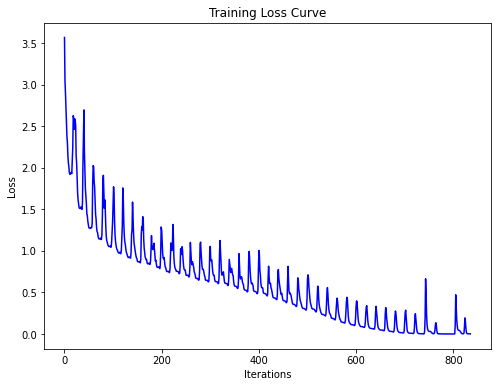

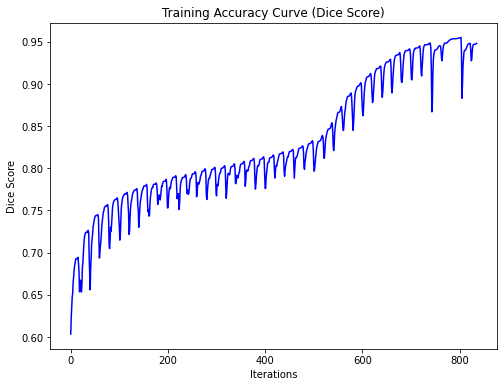

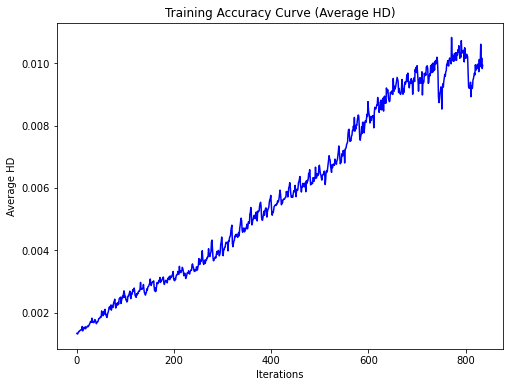

In [ ]:
import matplotlib.pyplot as plt
import pickle
import numpy as np

def plot_loss_curve(filepath, x_label, y_label, topic, blue=True):
    """
    Plots a loss curve given an array of loss values.

    Args:
    filepath: A string representing the file path of the loss values.
    x_label: A string representing the label for the x-axis.
    y_label: A string representing the label for the y-axis.
    topic: A string representing the title of the plot.
    blue: A boolean value indicating whether to plot the curve in blue or red.

    Returns:
    None
    """
    # Load the array using pickle.load()
    with open(filepath, 'rb') as file:
        loss_values = pickle.load(file)

    # Move tensors to the CPU and convert the list to a NumPy array
    loss_values = [t.cpu().numpy() if isinstance(t, torch.Tensor) else t for t in loss_values]
    loss_values = np.array(loss_values)

    # Set up the plot
    plt.figure(figsize=(8, 6))
    plt.title(topic)
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    # Plot the loss curve
    if blue:
        plt.plot(range(len(loss_values)), loss_values, 'b-')
    else:
        plt.plot(range(len(loss_values)), loss_values, 'r-')

    # Show the plot
    plt.show()

plot_loss_curve("/content/drive/MyDrive/Final-Year-Project/Final-Model/vanila-512-loss.pkl","Iterations","Loss","Training Loss Curve")
plot_loss_curve("/content/drive/MyDrive/Final-Year-Project/Final-Model/vanila-512-accuracy.pkl","Iterations","Dice Score","Training Accuracy Curve (Dice Score)")
plot_loss_curve("/content/drive/MyDrive/Final-Year-Project/Final-Model/vanila-512-hd.pkl","Iterations","Average HD","Training Accuracy Curve (Average HD)")

# Evaluate

In [48]:
def evaluation_hd(net, dataloader, device):
    net.eval()
    num_val_batches = len(dataloader)
    hd_distance = 0

    # iterate over the validation set
    for ix, (images,true_masks)  in enumerate(dataloader):

        image, mask_true = images,true_masks

        # move images and labels to correct device and type
        image = image.to(device=device, dtype=torch.float32)

        mask_true = mask_true.to(device=device, dtype=torch.long)
        
        mask_true = F.one_hot(mask_true, net.n_classes).permute(0, 3, 1, 2).float()

        with torch.no_grad():
            # predict the mask
            mask_pred = net(image)
        
            # convert to one-hot format
            if net.n_classes == 1:
                mask_pred = (F.sigmoid(mask_pred) > 0.5).float()
                # compute the averaged_hausdorff_distance

                hd_distance += averaged_hausdorff_distance(mask_pred.cpu(), mask_true.cpu())
            else:
                mask_pred = F.one_hot(mask_pred.argmax(dim=1), net.n_classes).permute(0, 3, 1, 2).float()

                # compute the averaged_hausdorff_distance, ignoring background
                hd_distance += averaged_hausdorff_distance(mask_pred[:, 1:, ...].cpu(), mask_true[:, 1:, ...].cpu())
    return hd_distance / num_val_batches


In [49]:
evaluation_hd(net, test_loader, device)

50.11411590576172

In [37]:
import torch
import torch.nn.functional as F
from tqdm import tqdm

# TODO: See what eval metric they use change accordingly.

def evaluate(net, dataloader, device):
    net.eval()
    num_val_batches = len(dataloader)
    dice_score = 0

    # iterate over the validation set
    for ix, (images,true_masks)  in enumerate(dataloader):

        image, mask_true = images,true_masks

        # move images and labels to correct device and type
        image = image.to(device=device, dtype=torch.float32)

        mask_true = mask_true.to(device=device, dtype=torch.long)
        
        mask_true = F.one_hot(mask_true, net.n_classes).permute(0, 3, 1, 2).float()

        with torch.no_grad():
            # predict the mask
            mask_pred = net(image)
            # print(torch.is_tensor(mask_pred))
            # print(torch.is_tensor(mask_true))
            # convert to one-hot format
            if net.n_classes == 1:
                mask_pred = (F.sigmoid(mask_pred) > 0.5).float()
                # compute the Dice score

                dice_score += dice_coeff(mask_pred, mask_true, reduce_batch_first=False)
            else:
                mask_pred = F.one_hot(mask_pred.argmax(dim=1), net.n_classes).permute(0, 3, 1, 2).float()

                # compute the Dice score, ignoring background
                dice_score += multiclass_dice_coeff(mask_pred[:, 1:, ...], mask_true[:, 1:, ...], reduce_batch_first=False)

    net.train()

    # Fixes a potential division by zero error
    if num_val_batches == 0:
        return dice_score
    return dice_score / num_val_batches

In [38]:
evaluate(net,test_loader,device)

tensor(0.6419, device='cuda:0')

In [ ]:
# def final_scoe(net, dataloader, device):
#     net.eval()
#     num_val_batches = len(dataloader)
#     dice_score = 0
#     hd_score = 0

#     # iterate over the validation set
#     for ix, (images,true_masks)  in enumerate(dataloader):

#         image, mask_true = images,true_masks

#         # move images and labels to correct device and type
#         image = image.to(device=device, dtype=torch.float32)

#         mask_true = mask_true.to(device=device, dtype=torch.long)
        
#         mask_true = F.one_hot(mask_true, net.n_classes).permute(0, 3, 1, 2).float()
#         with torch.no_grad():
#         # predict the mask
#           mask_pred = net(image)
#           # print(torch.is_tensor(mask_pred))
#           # print(torch.is_tensor(mask_true))
#           # convert to one-hot format
#           if net.n_classes == 1:
#               mask_pred = (F.sigmoid(mask_pred) > 0.5).float()
#               # compute the Dice score

#               dice_score += dice_coeff(mask_pred, mask_true, reduce_batch_first=False)
#               hd_score += averaged_hausdorff_distance(mask_pred.cpu(), mask_true.cpu(), reduce_batch_first = False)

#           else:
#               mask_pred = F.one_hot(mask_pred.argmax(dim=1), net.n_classes).permute(0, 3, 1, 2).float()

#               # compute the Dice score, ignoring background
#               dice_score += multiclass_dice_coeff(mask_pred[:, 1:, ...], mask_true[:, 1:, ...], reduce_batch_first=False)
#               hd_score += averaged_hausdorff_distance(mask_pred[:, 1:, ...],mask_true[:, 1:, ...], reduce_batch_first= False)
          
#         net.train()

#         final_eval_score = 

#     net.train()
  


# Display Predicted Image

In [39]:
def plot_pred_images(image,gt_image,pred_image):
  
    fig = plt.figure(figsize=(15, 15))

    plt.subplot(1, 3, 1)
    plt.imshow(image.permute(1,2,0).reshape(200,200))
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(gt_image.reshape(200,200))
    plt.title('Ground Truth')
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(pred_image)
    plt.title('Prediction')
    plt.axis('off')
    plt.show()

In [40]:
def predict_img(net,full_img,groud_truth,device):
    net.eval()

    with torch.no_grad():
      
        output = net(full_img.to(device))

        final_mask_batch = []

        for img in output:
          final_mask = np.argmax(img.cpu().detach().numpy(), axis=0)
          final_mask_batch.append(final_mask)

        final_mask_batch = np.array(final_mask_batch)

    for img, lbl, pred in zip(full_img,groud_truth,final_mask_batch):
      plot_pred_images(img, lbl, pred)

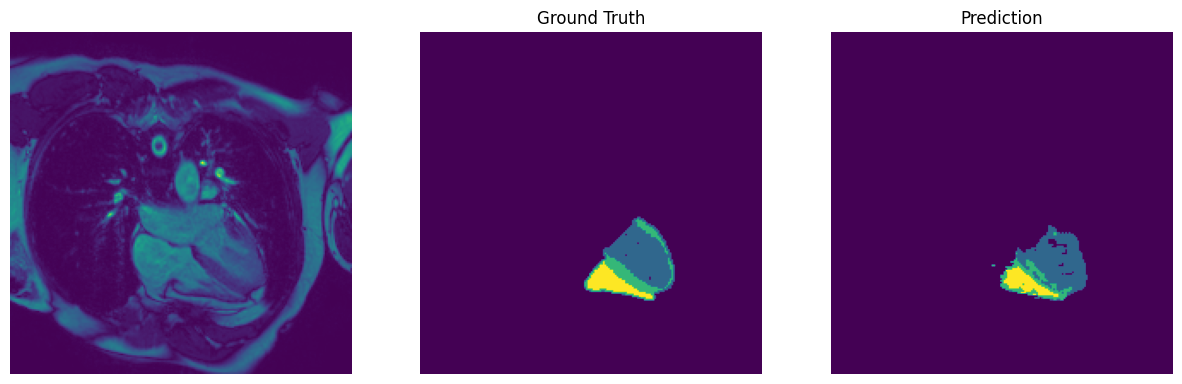

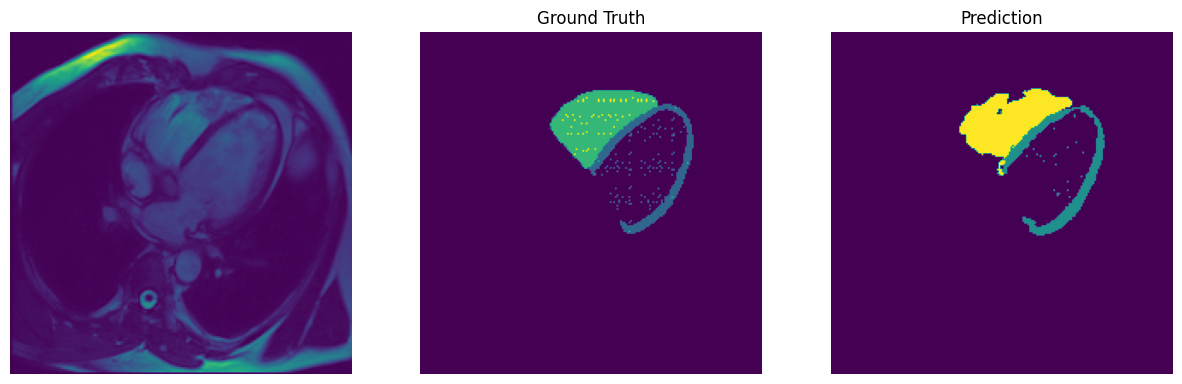

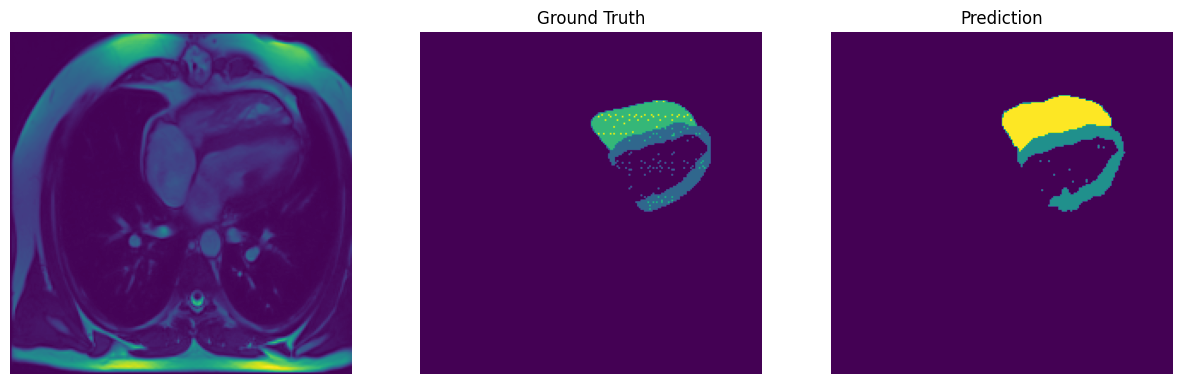

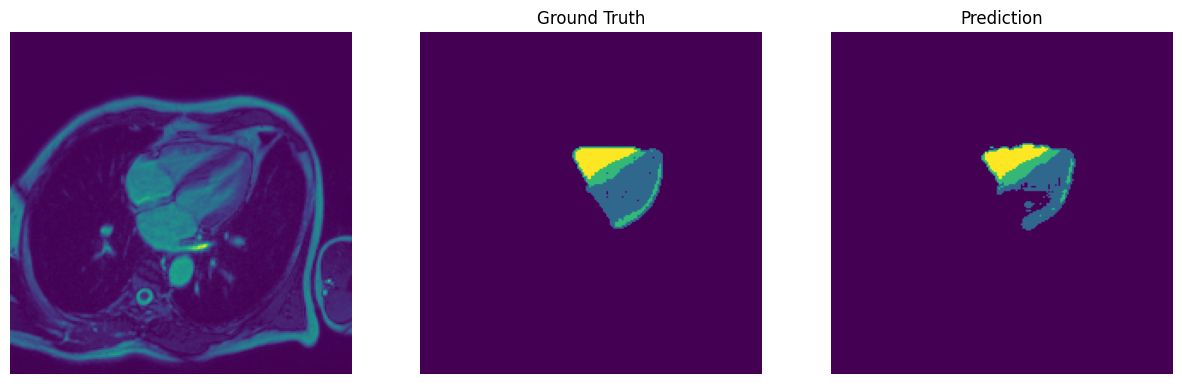

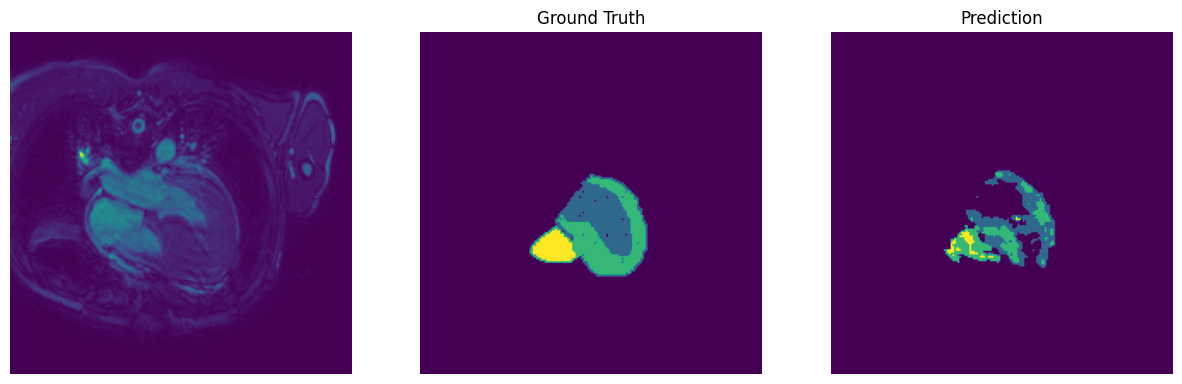

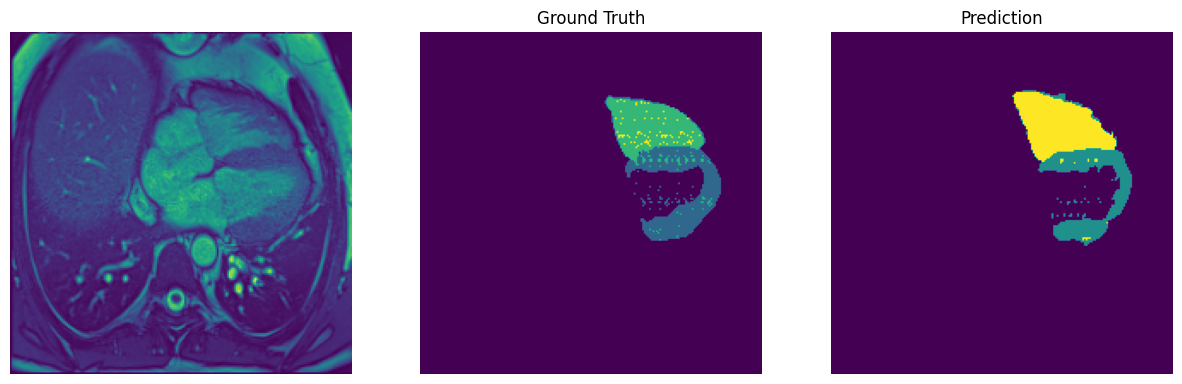

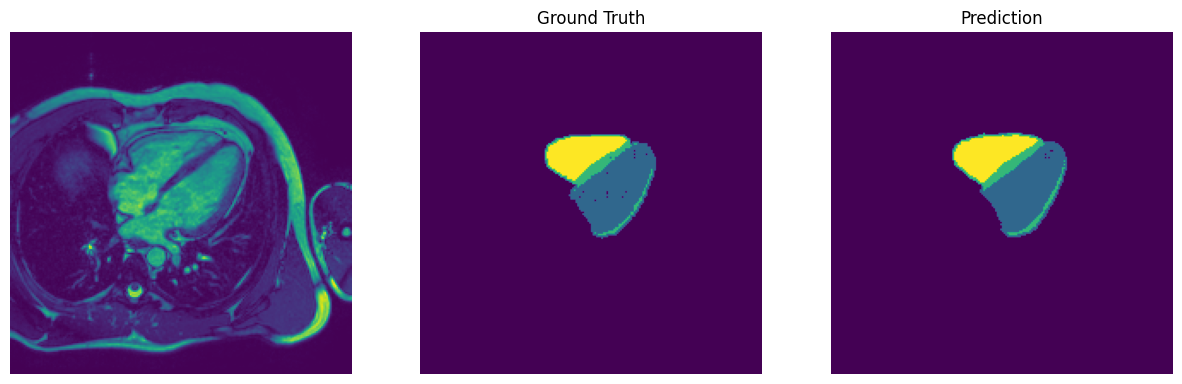

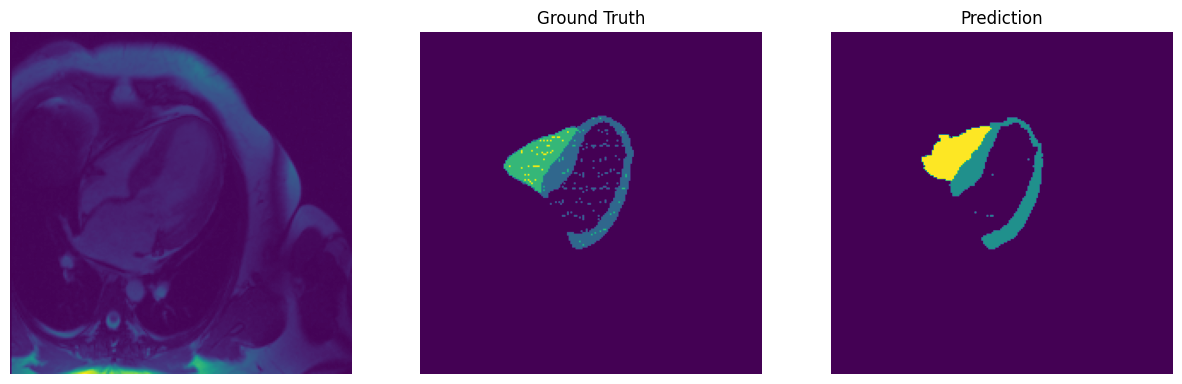

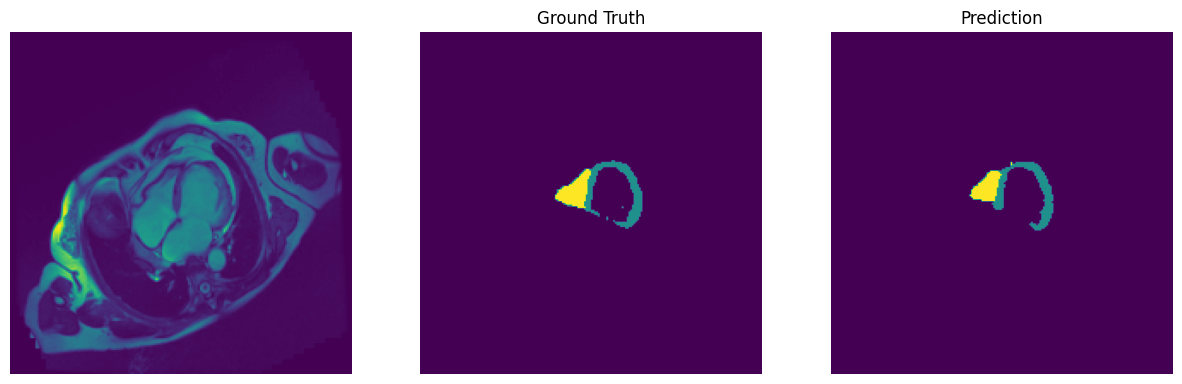

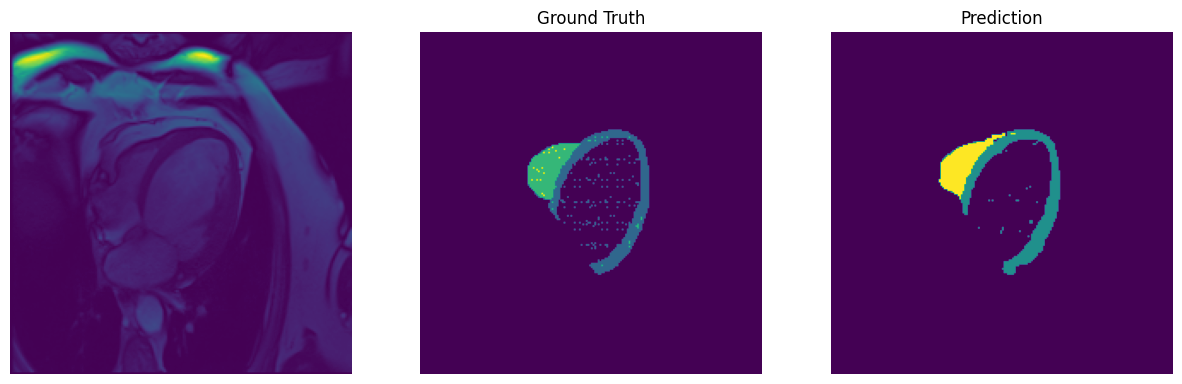

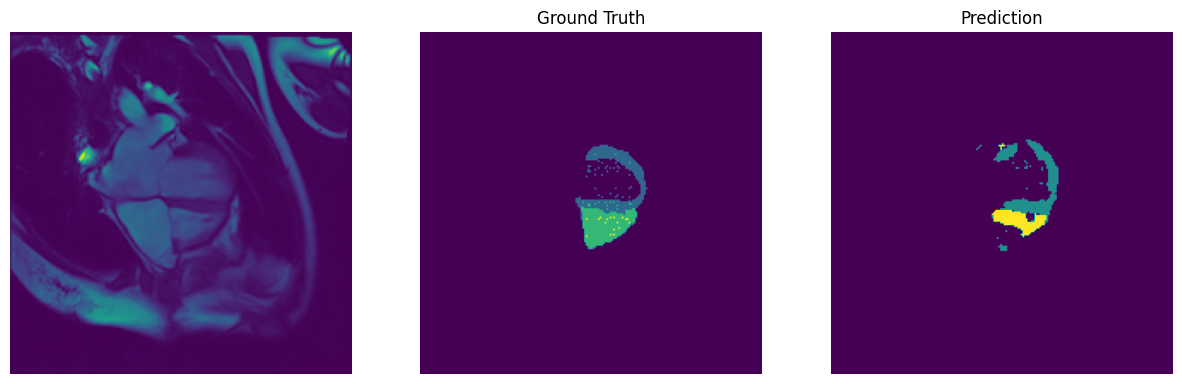

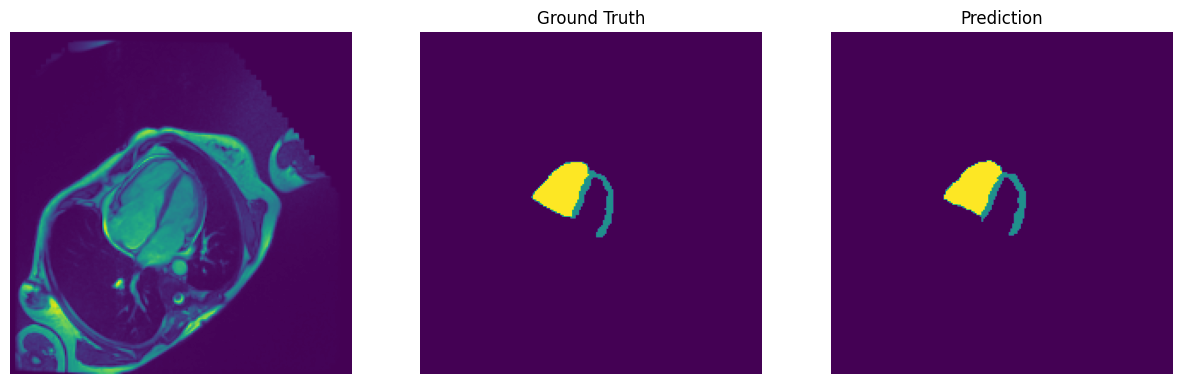

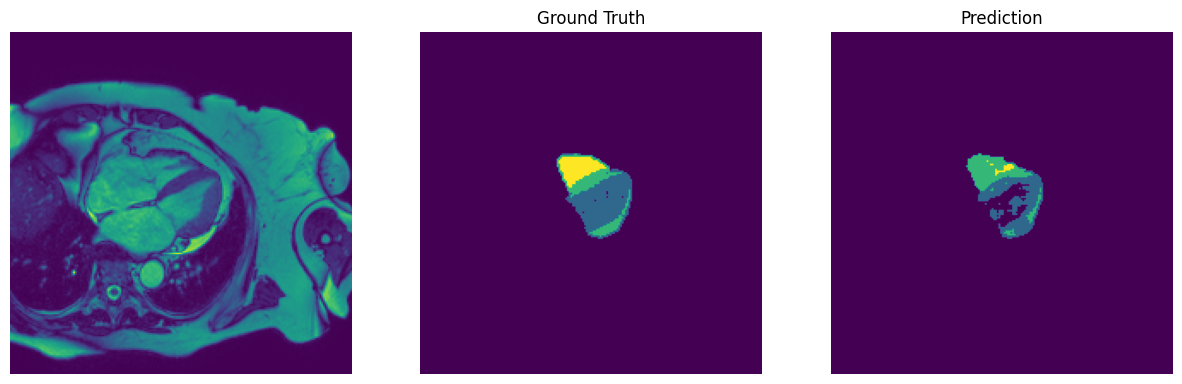

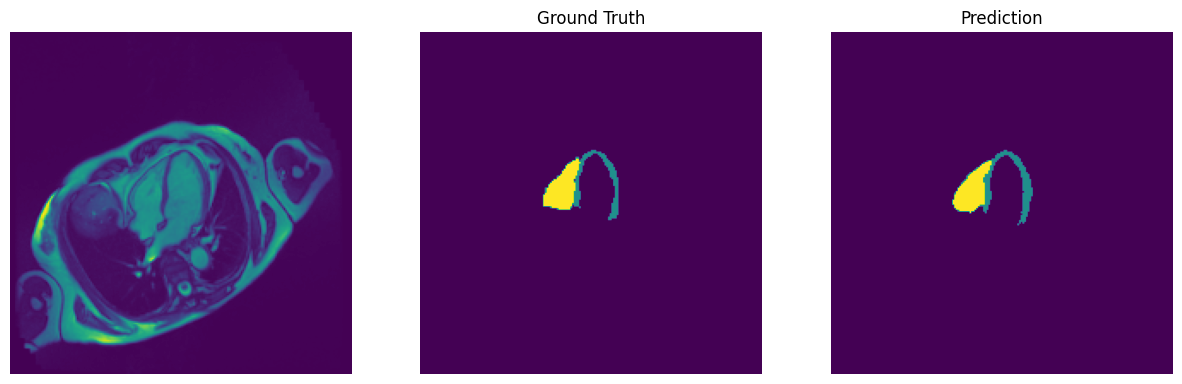

In [41]:
inputs, classes = next(iter(test_loader))
predict_img(net,inputs, classes,device)